# ANÁLISIS DINÁMICO BÁSICO DE CARTERAS

# Análisis de Carteras: Efecto de la Evolución de Precios y el Rebalanceo

Hasta el momento, nuestros estudios de las diferentes estrategias de carteras se han centrado en la selección de activos y la asignación de pesos sin considerar la evolución temporal de los precios de los activos ni la posibilidad de realizar ajustes periódicos o rebalanceo. Estos factores pueden tener un impacto significativo en el rendimiento y el riesgo de las carteras.

En este notebook, exploraremos un análisis básico que incorpora tanto la dinámica de los precios de los activos como la estrategia de rebalanceo. Examinaremos cómo estos elementos afectan la evolución del valor de diferentes carteras a lo largo del tiempo, permitiéndonos obtener una comprensión más profunda de cada estrategia de inversión en un contexto más dinámico y realista.



## Ejercicio guiado: Construcción y comparación de carteras con rebalanceos

En este notebook vamos a construir y comparar varias estrategias de cartera usando datos históricos de un conjunto de activos. El objetivo es entender **cómo cambia el comportamiento de las carteras** cuando:
- recalculamos los pesos periódicamente (*rebalanceo*), y
- estimamos los parámetros con una **ventana móvil** de datos recientes.

### Qué haremos
Calcularemos (al menos) estas carteras:
- **Equiponderada (EW)**
- **Mínima volatilidad (MinVol)**
- **Máximo ratio de Sharpe (Max Sharpe / Tangency)**
- **Risk Parity (RP)**

### Calendario del experimento
- **Rebalanceo:** el **primer día de cada mes**.
- **Frecuencia de actualización de pesos:** cada **3 meses** (rebalanceo trimestral).
- **Ventana de estimación:** para cada actualización, usaremos los **últimos 5 años (60 meses)** de datos para estimar retornos y covarianzas y calcular los pesos.
- Los pesos calculados en cada fecha se aplicarán durante el **siguiente periodo** hasta el próximo rebalanceo.

### Resultado esperado
Al final compararemos las estrategias mediante la **evolución del valor/índice de cada cartera** y analizaremos diferencias en estabilidad, concentración y respuesta en periodos de mercado distintos.

> Iremos construyendo todo el flujo **paso a paso** en las siguientes secciones.


<p align="center">
<img src="https://drive.google.com/uc?export=view&id=1UMNhBo6KtI8jdZo6W--fvnK0c1kaW3kW"

</p>



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import cvxpy as cp
from tqdm.auto import tqdm
import statsmodels.api as sm
import warnings
from scipy.linalg import sqrtm

plt.style.use('ggplot')
warnings.simplefilter(action='ignore', category=FutureWarning)


In [3]:
start_date = '1995-01-01'
precios_indice = yf.download("SPY", start=start_date)[["Close"]] # Precios ajustados al cierre

[*********************100%***********************]  1 of 1 completed


In [7]:
filepath = 'https://raw.githubusercontent.com/alfonso-santos/microcredencial-carteras-python-2023/main/Tema_5_APT/data/sp500_tickers.csv'
tickers_sp500 = list(pd.read_csv(filepath))

precios = yf.download(tickers_sp500, start=start_date)['Close']

precios_activos_sp500 = precios.copy()
precios_activos_sp500.dropna(axis=1, inplace=True)
ret_activos_sp500 = np.log(precios_activos_sp500).diff().dropna()

[*********************100%***********************]  503 of 503 completed

33 Failed downloads:
['MKC']: Timeout('Failed to perform, curl: (28) Operation timed out after 10005 milliseconds with 154049 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
['DD']: Timeout('Failed to perform, curl: (28) Operation timed out after 10015 milliseconds with 133689 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
['CLX']: Timeout('Failed to perform, curl: (28) Operation timed out after 10001 milliseconds with 121279 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
['NOC']: Timeout('Failed to perform, curl: (28) Operation timed out after 10004 milliseconds with 58755 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
['JNPR', 'WRK', 'CTLT', 'ANSS', 'WBA', 'PEAK', 'DFS', 'BRK.B', 'FLT', 'FI', 'PXD', 'HES', 'MRO', 'PARA', 'CDAY']: YFTzM

Elegimos un universo de activos formados por num_act_max activos elegidos aleatoriamente para generar las carteras

In [8]:
num_act_max = 50

num_columnas = precios_activos_sp500.shape[1]

# Generar índices aleatorios para seleccionar num_act_max activos sin repetición

# Fijar la semilla del generador de números aleatorios
np.random.seed(42)  # Puedes usar cualquier número entero como semilla

indices_aleatorios = np.random.choice(num_columnas, size=50, replace=False)

# Seleccionar las columnas del array original usando los índices aleatorios
precios_activos_select = precios_activos_sp500.iloc[:, indices_aleatorios]



## Paso 1 — Construir el calendario de rebalanceo y las ventanas de estimación

Antes de calcular cualquier cartera, necesitamos definir **cuándo** se recalculan los pesos y **qué datos** se usan en cada recalculación. En este paso vamos a construir:

- Las fechas del **primer** y **último** día disponible de cada mes.
- Las fechas de **rebalanceo trimestral** (cada 3 meses), tomando como referencia el **primer día de mes**.
- Las fechas de **fin de cada periodo** de rebalanceo (último día del tercer mes).
- Las fechas de **inicio de la ventana de estimación** (lookback de 60 meses) para cada rebalanceo.


In [11]:
# Paso 1.1: Obtener fechas disponibles y construir primer/último día de cada mes

# Obtener el índice de fechas del DataFrame de precios
fechas_disponibles = precios_activos_select.index
print("=" * 80)
print("PASO 1.1: FECHAS DEL PRIMER Y ÚLTIMO DÍA DE CADA MES")
print("=" * 80)
print(f"\nFecha inicial de los datos: {fechas_disponibles[0]}")
print(f"Fecha final de los datos: {fechas_disponibles[-1]}")
print(f"Total de días disponibles: {len(fechas_disponibles)}")

# Agrupamos por año-mes y obtenemos el primer y último día de cada mes
fechas_por_mes = fechas_disponibles.to_period('M').unique()
print(f"\nTotal de meses disponibles: {len(fechas_por_mes)}")

# Crear listas para almacenar primer y último día de cada mes
primer_dia_mes = []
ultimo_dia_mes = []

for periodo_mes in fechas_por_mes:
    # Filtrar fechas que pertenecen a este mes
    fechas_del_mes = fechas_disponibles[fechas_disponibles.to_period('M') == periodo_mes]
    
    if len(fechas_del_mes) > 0:
        primer_dia_mes.append(fechas_del_mes[0])
        ultimo_dia_mes.append(fechas_del_mes[-1])

# Convertir a Series para facilitar el trabajo posterior
primer_dia_mes = pd.Series(primer_dia_mes, name='primer_dia')
ultimo_dia_mes = pd.Series(ultimo_dia_mes, name='ultimo_dia')

print(f"\nPrimeros 5 meses - Primer día:")
print(primer_dia_mes.head())
print(f"\nÚltimos 5 meses - Último día:")
print(ultimo_dia_mes.tail())
print("\nPaso 1.1 completado")

PASO 1.1: FECHAS DEL PRIMER Y ÚLTIMO DÍA DE CADA MES

Fecha inicial de los datos: 1995-01-03 00:00:00
Fecha final de los datos: 2026-01-23 00:00:00
Total de días disponibles: 7817

Total de meses disponibles: 373

Primeros 5 meses - Primer día:
0   1995-01-03
1   1995-02-01
2   1995-03-01
3   1995-04-03
4   1995-05-01
Name: primer_dia, dtype: datetime64[ns]

Últimos 5 meses - Último día:
368   2025-09-30
369   2025-10-31
370   2025-11-28
371   2025-12-31
372   2026-01-23
Name: ultimo_dia, dtype: datetime64[ns]

Paso 1.1 completado


In [12]:
# Paso 1.2: Construir fechas de rebalanceo trimestral

# El rebalanceo se hace cada 3 meses, empezando desde el primer mes disponible
# Seleccionamos cada tercer mes desde el inicio (primer día de cada mes)
print("=" * 80)
print("PASO 1.2: FECHAS DE REBALANCEO TRIMESTRAL")
print("=" * 80)
print("Criterio: Primer día de cada mes, cada 3 meses (trimestral)")

# Seleccionar cada tercer mes desde el inicio
rebalan_fechas = primer_dia_mes[::3].reset_index(drop=True)

print(f"\nTotal de fechas de rebalanceo: {len(rebalan_fechas)}")
print(f"Primera fecha de rebalanceo: {rebalan_fechas.iloc[0]}")
print(f"Última fecha de rebalanceo: {rebalan_fechas.iloc[-1]}")
print(f"\nPrimeras 5 fechas de rebalanceo:")
print(rebalan_fechas.head())
print(f"\nÚltimas 5 fechas de rebalanceo:")
print(rebalan_fechas.tail())
print("\nPaso 1.2 completado")

PASO 1.2: FECHAS DE REBALANCEO TRIMESTRAL
Criterio: Primer día de cada mes, cada 3 meses (trimestral)

Total de fechas de rebalanceo: 125
Primera fecha de rebalanceo: 1995-01-03 00:00:00
Última fecha de rebalanceo: 2026-01-02 00:00:00

Primeras 5 fechas de rebalanceo:
0   1995-01-03
1   1995-04-03
2   1995-07-03
3   1995-10-02
4   1996-01-02
Name: primer_dia, dtype: datetime64[ns]

Últimas 5 fechas de rebalanceo:
120   2025-01-02
121   2025-04-01
122   2025-07-01
123   2025-10-01
124   2026-01-02
Name: primer_dia, dtype: datetime64[ns]

Paso 1.2 completado


In [13]:
# Paso 1.3: Construir fechas de fin de cada periodo de rebalanceo

# Para cada fecha de rebalanceo, necesitamos el último día del tercer mes siguiente
print("=" * 80)
print("PASO 1.3: FECHAS DE FIN DE CADA PERIODO DE REBALANCEO")
print("=" * 80)
print("Criterio: Último día del tercer mes después de cada rebalanceo")

rebalan_fechas_final = []

for fecha_rebal in rebalan_fechas:
    # Calcular el tercer mes después de la fecha de rebalanceo
    # Sumamos 2 meses adicionales (mes actual + 2 meses = 3 meses en total)
    fecha_fin_periodo = fecha_rebal + pd.DateOffset(months=2)
    
    # Obtener el último día del mes correspondiente
    # Primero vamos al último día del mes
    ultimo_dia_del_mes = fecha_fin_periodo + pd.offsets.MonthEnd(0)
    
    # Buscar en nuestros datos disponibles el último día disponible de ese mes
    fechas_del_mes_fin = fechas_disponibles[
        (fechas_disponibles.to_period('M') == ultimo_dia_del_mes.to_period('M'))
    ]
    
    if len(fechas_del_mes_fin) > 0:
        rebalan_fechas_final.append(fechas_del_mes_fin[-1])
    else:
        # Si no hay datos para ese mes, usar el último día disponible antes
        fechas_anteriores = fechas_disponibles[fechas_disponibles <= ultimo_dia_del_mes]
        if len(fechas_anteriores) > 0:
            rebalan_fechas_final.append(fechas_anteriores[-1])
        else:
            # Caso extremo: usar la fecha calculada directamente
            rebalan_fechas_final.append(ultimo_dia_del_mes)

rebalan_fechas_final = pd.Series(rebalan_fechas_final, name='fecha_fin_periodo')

print(f"\nTotal de fechas de fin de periodo: {len(rebalan_fechas_final)}")
print(f"Primera fecha de fin de periodo: {rebalan_fechas_final.iloc[0]}")
print(f"Última fecha de fin de periodo: {rebalan_fechas_final.iloc[-1]}")
print(f"\nPrimeras 5 fechas de fin de periodo:")
print(rebalan_fechas_final.head())

# Verificar que cada periodo tiene 3 meses
print(f"\nVerificación de duración de periodos (primeros 5):")
for i in range(min(5, len(rebalan_fechas))):
    inicio = rebalan_fechas.iloc[i]
    fin = rebalan_fechas_final.iloc[i]
    meses = (fin.to_period('M') - inicio.to_period('M')).n
    print(f"  Periodo {i+1}: {inicio.date()} -> {fin.date()} ({meses+1} meses)")
print("\nPaso 1.3 completado")

PASO 1.3: FECHAS DE FIN DE CADA PERIODO DE REBALANCEO
Criterio: Último día del tercer mes después de cada rebalanceo

Total de fechas de fin de periodo: 125
Primera fecha de fin de periodo: 1995-03-31 00:00:00
Última fecha de fin de periodo: 2026-01-23 00:00:00

Primeras 5 fechas de fin de periodo:
0   1995-03-31
1   1995-06-30
2   1995-09-29
3   1995-12-29
4   1996-03-29
Name: fecha_fin_periodo, dtype: datetime64[ns]

Verificación de duración de periodos (primeros 5):
  Periodo 1: 1995-01-03 -> 1995-03-31 (3 meses)
  Periodo 2: 1995-04-03 -> 1995-06-30 (3 meses)
  Periodo 3: 1995-07-03 -> 1995-09-29 (3 meses)
  Periodo 4: 1995-10-02 -> 1995-12-29 (3 meses)
  Periodo 5: 1996-01-02 -> 1996-03-29 (3 meses)

Paso 1.3 completado


In [14]:
# Paso 1.4: Construir fechas de inicio de la ventana de estimación (lookback de 60 meses)

# Para cada fecha de rebalanceo, necesitamos 60 meses de datos hacia atrás
print("=" * 80)
print("PASO 1.4: FECHAS DE INICIO DE VENTANA DE ESTIMACIÓN (LOOKBACK 60 MESES)")
print("=" * 80)
print("Criterio: 60 meses antes de cada fecha de rebalanceo")

inicio_calc_fechas = []

for fecha_rebal in rebalan_fechas:
    # Calcular la fecha 60 meses antes
    fecha_inicio_ventana = fecha_rebal - pd.DateOffset(months=60)
    
    # Buscar el primer día disponible en nuestros datos que sea >= fecha_inicio_ventana
    fechas_disponibles_ventana = fechas_disponibles[fechas_disponibles >= fecha_inicio_ventana]
    
    if len(fechas_disponibles_ventana) > 0:
        # Tomar el primer día disponible de ese mes para consistencia
        primer_dia_ventana = fechas_disponibles_ventana[0]
        # Asegurarnos de que sea el primer día del mes si es posible
        primer_dia_mes_ventana = fechas_disponibles_ventana[
            fechas_disponibles_ventana.to_period('M') == primer_dia_ventana.to_period('M')
        ]
        if len(primer_dia_mes_ventana) > 0:
            inicio_calc_fechas.append(primer_dia_mes_ventana[0])
        else:
            inicio_calc_fechas.append(primer_dia_ventana)
    else:
        # Si no hay datos suficientes, usar la primera fecha disponible
        inicio_calc_fechas.append(fechas_disponibles[0])

inicio_calc_fechas = pd.Series(inicio_calc_fechas, name='fecha_inicio_ventana')

print(f"\nTotal de fechas de inicio de ventana: {len(inicio_calc_fechas)}")
print(f"Primera fecha de inicio de ventana: {inicio_calc_fechas.iloc[0]}")
print(f"Última fecha de inicio de ventana: {inicio_calc_fechas.iloc[-1]}")

# Verificar que tenemos suficientes datos para cada ventana
print(f"\nVerificación de ventanas de estimación (primeros 5):")
for i in range(min(5, len(rebalan_fechas))):
    inicio_ventana = inicio_calc_fechas.iloc[i]
    fin_ventana = rebalan_fechas.iloc[i]
    meses_disponibles = (fin_ventana.to_period('M') - inicio_ventana.to_period('M')).n + 1
    print(f"  Ventana {i+1}: {inicio_ventana.date()} -> {fin_ventana.date()} ({meses_disponibles} meses disponibles)")
print("\nPaso 1.4 completado")

PASO 1.4: FECHAS DE INICIO DE VENTANA DE ESTIMACIÓN (LOOKBACK 60 MESES)
Criterio: 60 meses antes de cada fecha de rebalanceo

Total de fechas de inicio de ventana: 125
Primera fecha de inicio de ventana: 1995-01-03 00:00:00
Última fecha de inicio de ventana: 2021-01-04 00:00:00

Verificación de ventanas de estimación (primeros 5):
  Ventana 1: 1995-01-03 -> 1995-01-03 (1 meses disponibles)
  Ventana 2: 1995-01-03 -> 1995-04-03 (4 meses disponibles)
  Ventana 3: 1995-01-03 -> 1995-07-03 (7 meses disponibles)
  Ventana 4: 1995-01-03 -> 1995-10-02 (10 meses disponibles)
  Ventana 5: 1995-01-03 -> 1996-01-02 (13 meses disponibles)

Paso 1.4 completado


In [15]:
# Paso 1.5: Crear DataFrame resumen con todas las fechas importantes

print("=" * 80)
print("PASO 1.5: RESUMEN DEL CALENDARIO DE REBALANCEO")
print("=" * 80)

# Crear un DataFrame resumen con todas las fechas importantes
calendario_rebalanceo = pd.DataFrame({
    'rebalan_fecha': rebalan_fechas,
    'rebalan_fecha_final': rebalan_fechas_final,
    'inicio_ventana_estimacion': inicio_calc_fechas
})

print(f"\nDataFrame creado con {len(calendario_rebalanceo)} periodos de rebalanceo")
print(f"\nPrimeras 5 filas del calendario:")
print(calendario_rebalanceo.head())
print(f"\nÚltimas 5 filas del calendario:")
print(calendario_rebalanceo.tail())

print("\n" + "=" * 80)
print("PASO 1 COMPLETADO: Calendario de rebalanceo construido exitosamente")
print("=" * 80)

PASO 1.5: RESUMEN DEL CALENDARIO DE REBALANCEO

DataFrame creado con 125 periodos de rebalanceo

Primeras 5 filas del calendario:
  rebalan_fecha rebalan_fecha_final inicio_ventana_estimacion
0    1995-01-03          1995-03-31                1995-01-03
1    1995-04-03          1995-06-30                1995-01-03
2    1995-07-03          1995-09-29                1995-01-03
3    1995-10-02          1995-12-29                1995-01-03
4    1996-01-02          1996-03-29                1995-01-03

Últimas 5 filas del calendario:
    rebalan_fecha rebalan_fecha_final inicio_ventana_estimacion
120    2025-01-02          2025-03-31                2020-01-02
121    2025-04-01          2025-06-30                2020-04-01
122    2025-07-01          2025-09-30                2020-07-01
123    2025-10-01          2025-12-31                2020-10-01
124    2026-01-02          2026-01-23                2021-01-04

PASO 1 COMPLETADO: Calendario de rebalanceo construido exitosamente


In [17]:
# Paso 2.0: Verificación y alineación de variables del Paso 1 con Paso 2

print("=" * 80)
print("PASO 2.0: VERIFICACIÓN Y ALINEACIÓN DE VARIABLES")
print("=" * 80)

# Verificar que las variables del Paso 1 existen y están correctamente nombradas
# Las variables del Paso 1 deben coincidir con lo que se espera en el Paso 2

print("\nVerificando variables del Paso 1:")
print(f"  - primer_dia_mes: {'OK' if 'primer_dia_mes' in globals() else 'FALTA'}")
print(f"  - ultimo_dia_mes: {'OK' if 'ultimo_dia_mes' in globals() else 'FALTA'}")
print(f"  - rebalan_fechas: {'OK' if 'rebalan_fechas' in globals() else 'FALTA'}")
print(f"  - rebalan_fechas_final: {'OK' if 'rebalan_fechas_final' in globals() else 'FALTA'}")
print(f"  - inicio_calc_fechas: {'OK' if 'inicio_calc_fechas' in globals() else 'FALTA'}")

# Asegurar que las variables tienen los nombres correctos según el Paso 2
# El Paso 2 espera:
# - rebalan_fechas (ya existe del Paso 1)
# - rebalan_fechas_final (ya existe del Paso 1)

# Verificar tipos y dimensiones
if 'rebalan_fechas' in globals():
    print(f"\n  rebalan_fechas: {type(rebalan_fechas).__name__}, longitud: {len(rebalan_fechas)}")
if 'rebalan_fechas_final' in globals():
    print(f"  rebalan_fechas_final: {type(rebalan_fechas_final).__name__}, longitud: {len(rebalan_fechas_final)}")
if 'primer_dia_mes' in globals():
    print(f"  primer_dia_mes: {type(primer_dia_mes).__name__}, longitud: {len(primer_dia_mes)}")
if 'ultimo_dia_mes' in globals():
    print(f"  ultimo_dia_mes: {type(ultimo_dia_mes).__name__}, longitud: {len(ultimo_dia_mes)}")

print("\nVariables del Paso 1 alineadas correctamente para el Paso 2")
print("Paso 2.0 completado")

PASO 2.0: VERIFICACIÓN Y ALINEACIÓN DE VARIABLES

Verificando variables del Paso 1:
  - primer_dia_mes: OK
  - ultimo_dia_mes: OK
  - rebalan_fechas: OK
  - rebalan_fechas_final: OK
  - inicio_calc_fechas: OK

  rebalan_fechas: Series, longitud: 125
  rebalan_fechas_final: Series, longitud: 125
  primer_dia_mes: Series, longitud: 373
  ultimo_dia_mes: Series, longitud: 373

Variables del Paso 1 alineadas correctamente para el Paso 2
Paso 2.0 completado


In [18]:
# Paso 2.1: Extraer precios del primer y último día de cada mes

print("=" * 80)
print("PASO 2.1: PRECIOS DEL PRIMER Y ÚLTIMO DÍA DE CADA MES")
print("=" * 80)

# Extraer los precios del primer día de cada mes usando las fechas que ya calculamos
# Usamos primer_dia_mes que contiene el primer día disponible de cada mes
precios_activos_mes_ini = precios_activos_select.loc[primer_dia_mes]

print(f"\nPrecios del primer día de cada mes:")
print(f"  Dimensiones: {precios_activos_mes_ini.shape}")
print(f"  Fecha inicial: {precios_activos_mes_ini.index[0]}")
print(f"  Fecha final: {precios_activos_mes_ini.index[-1]}")
print(f"  Total de meses: {len(precios_activos_mes_ini)}")
print(f"  Número de activos: {precios_activos_mes_ini.shape[1]}")

# Extraer los precios del último día de cada mes usando las fechas que ya calculamos
# Usamos ultimo_dia_mes que contiene el último día disponible de cada mes
precios_activos_mes_fin = precios_activos_select.loc[ultimo_dia_mes]

print(f"\nPrecios del último día de cada mes:")
print(f"  Dimensiones: {precios_activos_mes_fin.shape}")
print(f"  Fecha inicial: {precios_activos_mes_fin.index[0]}")
print(f"  Fecha final: {precios_activos_mes_fin.index[-1]}")
print(f"  Total de meses: {len(precios_activos_mes_fin)}")
print(f"  Número de activos: {precios_activos_mes_fin.shape[1]}")

# Verificar que ambas series tienen las mismas fechas (meses)
print(f"\nVerificación:")
print(f"  ¿Mismas fechas? {precios_activos_mes_ini.index.equals(precios_activos_mes_fin.index)}")
print(f"  Primeros 3 meses - Primer día:")
print(precios_activos_mes_ini.head(3).index.tolist())
print(f"  Primeros 3 meses - Último día:")
print(precios_activos_mes_fin.head(3).index.tolist())

print("\nPaso 2.1 completado")

PASO 2.1: PRECIOS DEL PRIMER Y ÚLTIMO DÍA DE CADA MES

Precios del primer día de cada mes:
  Dimensiones: (373, 50)
  Fecha inicial: 1995-01-03 00:00:00
  Fecha final: 2026-01-02 00:00:00
  Total de meses: 373
  Número de activos: 50

Precios del último día de cada mes:
  Dimensiones: (373, 50)
  Fecha inicial: 1995-01-31 00:00:00
  Fecha final: 2026-01-23 00:00:00
  Total de meses: 373
  Número de activos: 50

Verificación:
  ¿Mismas fechas? False
  Primeros 3 meses - Primer día:
[Timestamp('1995-01-03 00:00:00'), Timestamp('1995-02-01 00:00:00'), Timestamp('1995-03-01 00:00:00')]
  Primeros 3 meses - Último día:
[Timestamp('1995-01-31 00:00:00'), Timestamp('1995-02-28 00:00:00'), Timestamp('1995-03-31 00:00:00')]

Paso 2.1 completado


## Paso 2 — Precios “mensuales”, retornos y precios en fechas de rebalanceo

Con el calendario ya definido, ahora necesitamos construir las series que usaremos para **calcular las carteras** y para **simular el rebalanceo**.

En este paso:

- Extraemos los **precios del primer día de cada mes** (`precios_activos_mes_ini`) y del **último día de cada mes** (`precios_activos_mes_fin`).
- A partir de esos precios calculamos los **retornos mensuales (log-retornos)**:
  - `ret_activos_mes_ini`: retornos *primer día → primer día* (coherente si rebalanceamos el primer día del mes).
  - `ret_activos_mes_fin`: retornos *último día → último día* (alternativa si se rebalanceara a fin de mes).
- Extraemos también los **precios en las fechas exactas de rebalanceo**:
  - `precios_rebalan`: precios en cada `rebalan_fechas` (inicio de periodo).
  - `precios_rebalan_final`: precios en cada `rebalan_fechas_final` (fin de periodo).

Estas series serán la base para estimar parámetros (μ, Σ), calcular pesos y evaluar el comportamiento de cada cartera.


In [19]:
# Paso 2.2: Calcular retornos mensuales (log-retornos)

print("=" * 80)
print("PASO 2.2: RETORNOS MENSUALES (LOG-RETORNOS)")
print("=" * 80)

# Calcular retornos mensuales usando log-retornos
# ret_activos_mes_ini: retornos primer día → primer día (coherente si rebalanceamos el primer día del mes)
# Usamos diff() sobre el logaritmo de los precios para obtener log-retornos
ret_activos_mes_ini = np.log(precios_activos_mes_ini).diff().dropna()

print(f"\nRetornos mensuales (primer día → primer día):")
print(f"  Dimensiones: {ret_activos_mes_ini.shape}")
print(f"  Fecha inicial: {ret_activos_mes_ini.index[0]}")
print(f"  Fecha final: {ret_activos_mes_ini.index[-1]}")
print(f"  Total de meses: {len(ret_activos_mes_ini)}")
print(f"  Número de activos: {ret_activos_mes_ini.shape[1]}")

# Verificar estadísticas básicas
print(f"\nEstadísticas básicas de ret_activos_mes_ini:")
print(f"  Media por activo (primeros 5 activos):")
print(ret_activos_mes_ini.mean().head())
print(f"  Volatilidad por activo (primeros 5 activos):")
print(ret_activos_mes_ini.std().head())

# ret_activos_mes_fin: retornos último día → último día (alternativa si se rebalanceara a fin de mes)
ret_activos_mes_fin = np.log(precios_activos_mes_fin).diff().dropna()

print(f"\nRetornos mensuales (último día → último día):")
print(f"  Dimensiones: {ret_activos_mes_fin.shape}")
print(f"  Fecha inicial: {ret_activos_mes_fin.index[0]}")
print(f"  Fecha final: {ret_activos_mes_fin.index[-1]}")
print(f"  Total de meses: {len(ret_activos_mes_fin)}")
print(f"  Número de activos: {ret_activos_mes_fin.shape[1]}")

# Verificar estadísticas básicas
print(f"\nEstadísticas básicas de ret_activos_mes_fin:")
print(f"  Media por activo (primeros 5 activos):")
print(ret_activos_mes_fin.mean().head())
print(f"  Volatilidad por activo (primeros 5 activos):")
print(ret_activos_mes_fin.std().head())

# Verificar que ambas series tienen las mismas fechas (después de dropna)
print(f"\nVerificación:")
print(f"  ¿Mismas fechas? {ret_activos_mes_ini.index.equals(ret_activos_mes_fin.index)}")
print(f"  Primeras 3 fechas de ret_activos_mes_ini:")
print(ret_activos_mes_ini.head(3).index.tolist())
print(f"  Primeras 3 fechas de ret_activos_mes_fin:")
print(ret_activos_mes_fin.head(3).index.tolist())

print("\nPaso 2.2 completado")

PASO 2.2: RETORNOS MENSUALES (LOG-RETORNOS)

Retornos mensuales (primer día → primer día):
  Dimensiones: (372, 50)
  Fecha inicial: 1995-02-01 00:00:00
  Fecha final: 2026-01-02 00:00:00
  Total de meses: 372
  Número de activos: 50

Estadísticas básicas de ret_activos_mes_ini:
  Media por activo (primeros 5 activos):
Ticker
BBWI    0.006367
IEX     0.009519
PG      0.007993
KLAC    0.014268
UDR     0.007100
dtype: float64
  Volatilidad por activo (primeros 5 activos):
Ticker
BBWI    0.128217
IEX     0.079613
PG      0.054243
KLAC    0.126534
UDR     0.071093
dtype: float64

Retornos mensuales (último día → último día):
  Dimensiones: (372, 50)
  Fecha inicial: 1995-02-28 00:00:00
  Fecha final: 2026-01-23 00:00:00
  Total de meses: 372
  Número de activos: 50

Estadísticas básicas de ret_activos_mes_fin:
  Media por activo (primeros 5 activos):
Ticker
BBWI    0.006725
IEX     0.009760
PG      0.008013
KLAC    0.014603
UDR     0.007291
dtype: float64
  Volatilidad por activo (primeros

In [20]:
# Paso 2.3: Extraer precios en las fechas exactas de rebalanceo

print("=" * 80)
print("PASO 2.3: PRECIOS EN FECHAS EXACTAS DE REBALANCEO")
print("=" * 80)

# precios_rebalan: precios en cada rebalan_fechas (inicio de periodo)
# Necesitamos asegurarnos de que todas las fechas de rebalanceo estén disponibles en los datos
print("\nExtrayendo precios en fechas de inicio de rebalanceo...")

# Filtrar solo las fechas que existen en los datos
fechas_rebalan_disponibles = [fecha for fecha in rebalan_fechas if fecha in precios_activos_select.index]
fechas_rebalan_no_disponibles = [fecha for fecha in rebalan_fechas if fecha not in precios_activos_select.index]

if len(fechas_rebalan_no_disponibles) > 0:
    print(f"  Advertencia: {len(fechas_rebalan_no_disponibles)} fechas no están disponibles en los datos")
    print(f"  Buscando fechas más cercanas...")
    # Para fechas no disponibles, buscar la fecha más cercana anterior
    fechas_rebalan_ajustadas = []
    for fecha in rebalan_fechas:
        if fecha in precios_activos_select.index:
            fechas_rebalan_ajustadas.append(fecha)
        else:
            # Buscar la fecha más cercana anterior
            fechas_anteriores = precios_activos_select.index[precios_activos_select.index <= fecha]
            if len(fechas_anteriores) > 0:
                fechas_rebalan_ajustadas.append(fechas_anteriores[-1])
            else:
                # Si no hay fechas anteriores, usar la primera disponible
                fechas_rebalan_ajustadas.append(precios_activos_select.index[0])
    precios_rebalan = precios_activos_select.loc[fechas_rebalan_ajustadas]
else:
    precios_rebalan = precios_activos_select.loc[rebalan_fechas]

print(f"\nPrecios en fechas de inicio de rebalanceo (precios_rebalan):")
print(f"  Dimensiones: {precios_rebalan.shape}")
print(f"  Fecha inicial: {precios_rebalan.index[0]}")
print(f"  Fecha final: {precios_rebalan.index[-1]}")
print(f"  Total de fechas de rebalanceo: {len(precios_rebalan)}")
print(f"  Número de activos: {precios_rebalan.shape[1]}")

# precios_rebalan_final: precios en cada rebalan_fechas_final (fin de periodo)
print("\nExtrayendo precios en fechas de fin de periodo de rebalanceo...")

# Filtrar solo las fechas que existen en los datos
fechas_rebalan_final_disponibles = [fecha for fecha in rebalan_fechas_final if fecha in precios_activos_select.index]
fechas_rebalan_final_no_disponibles = [fecha for fecha in rebalan_fechas_final if fecha not in precios_activos_select.index]

if len(fechas_rebalan_final_no_disponibles) > 0:
    print(f"  Advertencia: {len(fechas_rebalan_final_no_disponibles)} fechas no están disponibles en los datos")
    print(f"  Buscando fechas más cercanas...")
    # Para fechas no disponibles, buscar la fecha más cercana anterior
    fechas_rebalan_final_ajustadas = []
    for fecha in rebalan_fechas_final:
        if fecha in precios_activos_select.index:
            fechas_rebalan_final_ajustadas.append(fecha)
        else:
            # Buscar la fecha más cercana anterior
            fechas_anteriores = precios_activos_select.index[precios_activos_select.index <= fecha]
            if len(fechas_anteriores) > 0:
                fechas_rebalan_final_ajustadas.append(fechas_anteriores[-1])
            else:
                # Si no hay fechas anteriores, usar la primera disponible
                fechas_rebalan_final_ajustadas.append(precios_activos_select.index[0])
    precios_rebalan_final = precios_activos_select.loc[fechas_rebalan_final_ajustadas]
else:
    precios_rebalan_final = precios_activos_select.loc[rebalan_fechas_final]

print(f"\nPrecios en fechas de fin de periodo (precios_rebalan_final):")
print(f"  Dimensiones: {precios_rebalan_final.shape}")
print(f"  Fecha inicial: {precios_rebalan_final.index[0]}")
print(f"  Fecha final: {precios_rebalan_final.index[-1]}")
print(f"  Total de fechas de fin de periodo: {len(precios_rebalan_final)}")
print(f"  Número de activos: {precios_rebalan_final.shape[1]}")

# Verificar que tenemos el mismo número de fechas de inicio y fin
print(f"\nVerificación:")
print(f"  Número de fechas de inicio: {len(precios_rebalan)}")
print(f"  Número de fechas de fin: {len(precios_rebalan_final)}")
print(f"  ¿Mismo número? {len(precios_rebalan) == len(precios_rebalan_final)}")

# Mostrar ejemplo de las primeras fechas
print(f"\nPrimeras 3 periodos de rebalanceo:")
for i in range(min(3, len(precios_rebalan))):
    print(f"  Periodo {i+1}:")
    print(f"    Inicio: {precios_rebalan.index[i]} -> Fin: {precios_rebalan_final.index[i]}")

print("\nPaso 2.3 completado")

PASO 2.3: PRECIOS EN FECHAS EXACTAS DE REBALANCEO

Extrayendo precios en fechas de inicio de rebalanceo...

Precios en fechas de inicio de rebalanceo (precios_rebalan):
  Dimensiones: (125, 50)
  Fecha inicial: 1995-01-03 00:00:00
  Fecha final: 2026-01-02 00:00:00
  Total de fechas de rebalanceo: 125
  Número de activos: 50

Extrayendo precios en fechas de fin de periodo de rebalanceo...

Precios en fechas de fin de periodo (precios_rebalan_final):
  Dimensiones: (125, 50)
  Fecha inicial: 1995-03-31 00:00:00
  Fecha final: 2026-01-23 00:00:00
  Total de fechas de fin de periodo: 125
  Número de activos: 50

Verificación:
  Número de fechas de inicio: 125
  Número de fechas de fin: 125
  ¿Mismo número? True

Primeras 3 periodos de rebalanceo:
  Periodo 1:
    Inicio: 1995-01-03 00:00:00 -> Fin: 1995-03-31 00:00:00
  Periodo 2:
    Inicio: 1995-04-03 00:00:00 -> Fin: 1995-06-30 00:00:00
  Periodo 3:
    Inicio: 1995-07-03 00:00:00 -> Fin: 1995-09-29 00:00:00

Paso 2.3 completado


In [ ]:
# Paso 3.1: Construir ventanas de estimación para cada fecha de rebalanceo

print("=" * 80)
print("PASO 3.1: CONSTRUIR VENTANAS DE ESTIMACIÓN")
print("=" * 80)

# Para cada fecha de rebalanceo, necesitamos construir una ventana de estimación
# con los retornos mensuales desde inicio_calc_fechas[i] hasta rebalan_fechas[i]

print(f"\nTotal de fechas de rebalanceo: {len(rebalan_fechas)}")
print(f"Usaremos ret_activos_mes_ini para construir las ventanas de estimación")

# Almacenar las ventanas de estimación
ventanas_estimacion = []

print("\nConstruyendo ventanas de estimación para cada fecha de rebalanceo...")

for i in range(len(rebalan_fechas)):
    fecha_inicio_ventana = inicio_calc_fechas.iloc[i]
    fecha_fin_ventana = rebalan_fechas.iloc[i]
    
    # Filtrar los retornos mensuales en el rango de la ventana
    # Usamos ret_activos_mes_ini que tiene retornos primer día → primer día
    ventana_ret = ret_activos_mes_ini[
        (ret_activos_mes_ini.index >= fecha_inicio_ventana) & 
        (ret_activos_mes_ini.index <= fecha_fin_ventana)
    ]
    
    # Verificar que tenemos datos suficientes
    if len(ventana_ret) < 12:  # Mínimo 12 meses para una estimación razonable
        print(f"  Advertencia: Ventana {i+1} tiene solo {len(ventana_ret)} meses de datos")
    
    ventanas_estimacion.append(ventana_ret)

print(f"\nVentanas de estimación construidas: {len(ventanas_estimacion)}")

# Mostrar información de las primeras ventanas
print("\nInformación de las primeras 3 ventanas:")
for i in range(min(3, len(ventanas_estimacion))):
    ventana = ventanas_estimacion[i]
    print(f"  Ventana {i+1}:")
    print(f"    Fecha inicio: {inicio_calc_fechas.iloc[i].date()}")
    print(f"    Fecha fin: {rebalan_fechas.iloc[i].date()}")
    print(f"    Meses disponibles: {len(ventana)}")
    print(f"    Activos: {ventana.shape[1]}")

print("\nPaso 3.1 completado")

In [ ]:
# Paso 3.2: Calcular pesos para cada estrategia (EW, MinVol, Max Sharpe, Risk Parity)

print("=" * 80)
print("PASO 3.2: CALCULAR PESOS PARA CADA ESTRATEGIA")
print("=" * 80)

# Definir retorno libre de riesgo mensual (asumimos 2% anual = 0.02/12 mensual)
ret_rf_mensual = 0.02 / 12
print(f"\nRetorno libre de riesgo mensual: {ret_rf_mensual:.6f} ({ret_rf_mensual*12*100:.2f}% anual)")

# Listas para almacenar los pesos de cada estrategia
pesos_ew = []  # Equiponderada
pesos_min_vol = []  # Mínima volatilidad
pesos_max_sharpe = []  # Máximo Sharpe
pesos_risk_parity = []  # Risk Parity

print("\nCalculando pesos para cada fecha de rebalanceo...")

# Iterar sobre cada ventana de estimación
for i, ventana_ret in enumerate(tqdm(ventanas_estimacion, desc="Calculando pesos")):
    # Verificar que la ventana tiene datos suficientes
    if len(ventana_ret) == 0:
        print(f"  Advertencia: Ventana {i+1} está vacía, usando pesos equiponderados")
        num_activos = ret_activos_mes_ini.shape[1]
        pesos_ew.append(np.ones(num_activos) / num_activos)
        pesos_min_vol.append(np.ones(num_activos) / num_activos)
        pesos_max_sharpe.append(np.ones(num_activos) / num_activos)
        pesos_risk_parity.append(np.ones(num_activos) / num_activos)
        continue
    
    # 1. Equiponderada (EW): 1/N para cada activo
    num_activos = ventana_ret.shape[1]
    pesos_ew_i = np.ones(num_activos) / num_activos
    pesos_ew.append(pesos_ew_i)
    
    # 2. Mínima volatilidad (MinVol)
    try:
        pesos_min_vol_i = cartera_min_vol(ventana_ret)
        pesos_min_vol.append(pesos_min_vol_i)
    except Exception as e:
        print(f"  Error en MinVol para ventana {i+1}: {e}, usando equiponderada")
        pesos_min_vol.append(pesos_ew_i)
    
    # 3. Máximo Sharpe (Max Sharpe)
    try:
        pesos_max_sharpe_i = cartera_max_sharpe(ventana_ret, ret_rf_mensual)
        pesos_max_sharpe.append(pesos_max_sharpe_i)
    except Exception as e:
        print(f"  Error en Max Sharpe para ventana {i+1}: {e}, usando equiponderada")
        pesos_max_sharpe.append(pesos_ew_i)
    
    # 4. Risk Parity
    try:
        pesos_risk_parity_i = cartera_risk_parity(ventana_ret)
        pesos_risk_parity.append(pesos_risk_parity_i)
    except Exception as e:
        print(f"  Error en Risk Parity para ventana {i+1}: {e}, usando equiponderada")
        pesos_risk_parity.append(pesos_ew_i)

print(f"\nPesos calculados para {len(pesos_ew)} fechas de rebalanceo")
print(f"  - Equiponderada (EW): {len(pesos_ew)} vectores")
print(f"  - Mínima volatilidad: {len(pesos_min_vol)} vectores")
print(f"  - Máximo Sharpe: {len(pesos_max_sharpe)} vectores")
print(f"  - Risk Parity: {len(pesos_risk_parity)} vectores")

# Verificar que todos los vectores tienen la misma longitud
longitud_esperada = len(pesos_ew[0]) if len(pesos_ew) > 0 else 0
print(f"\nVerificación:")
print(f"  Longitud esperada por vector: {longitud_esperada} (número de activos)")
print(f"  Primeros 5 pesos EW (primer rebalanceo): {pesos_ew[0][:5] if len(pesos_ew) > 0 else 'N/A'}")
print(f"  Suma de pesos EW (primer rebalanceo): {np.sum(pesos_ew[0]) if len(pesos_ew) > 0 else 'N/A':.6f}")

print("\nPaso 3.2 completado")

In [ ]:
# Paso 3.3: Crear DataFrames con los pesos

print("=" * 80)
print("PASO 3.3: CREAR DATAFRAMES CON LOS PESOS")
print("=" * 80)

# Obtener los nombres de los activos (columnas del DataFrame de retornos)
nombres_activos = ret_activos_mes_ini.columns.tolist()
print(f"\nNúmero de activos: {len(nombres_activos)}")

# Crear DataFrames con los pesos
# Filas = fechas de rebalanceo, Columnas = activos, Valores = pesos

# 1. Equiponderada (EW)
pesos_ini_ew = pd.DataFrame(
    pesos_ew,
    index=rebalan_fechas,
    columns=nombres_activos
)
print(f"\nDataFrame pesos_ini_ew:")
print(f"  Dimensiones: {pesos_ini_ew.shape}")
print(f"  Fechas: {len(pesos_ini_ew)} rebalanceos")
print(f"  Activos: {pesos_ini_ew.shape[1]}")

# 2. Mínima volatilidad (MinVol)
pesos_ini_min_vol = pd.DataFrame(
    pesos_min_vol,
    index=rebalan_fechas,
    columns=nombres_activos
)
print(f"\nDataFrame pesos_ini_min_vol:")
print(f"  Dimensiones: {pesos_ini_min_vol.shape}")
print(f"  Fechas: {len(pesos_ini_min_vol)} rebalanceos")
print(f"  Activos: {pesos_ini_min_vol.shape[1]}")

# 3. Máximo Sharpe
pesos_ini_max_sharpe = pd.DataFrame(
    pesos_max_sharpe,
    index=rebalan_fechas,
    columns=nombres_activos
)
print(f"\nDataFrame pesos_ini_max_sharpe:")
print(f"  Dimensiones: {pesos_ini_max_sharpe.shape}")
print(f"  Fechas: {len(pesos_ini_max_sharpe)} rebalanceos")
print(f"  Activos: {pesos_ini_max_sharpe.shape[1]}")

# 4. Risk Parity
pesos_ini_risk_parity = pd.DataFrame(
    pesos_risk_parity,
    index=rebalan_fechas,
    columns=nombres_activos
)
print(f"\nDataFrame pesos_ini_risk_parity:")
print(f"  Dimensiones: {pesos_ini_risk_parity.shape}")
print(f"  Fechas: {len(pesos_ini_risk_parity)} rebalanceos")
print(f"  Activos: {pesos_ini_risk_parity.shape[1]}")

# Verificar que las sumas de pesos son aproximadamente 1 para cada fecha
print(f"\nVerificación de sumas de pesos (primeras 3 fechas):")
for i in range(min(3, len(rebalan_fechas))):
    fecha = rebalan_fechas.iloc[i]
    print(f"  Fecha {fecha.date()}:")
    print(f"    EW: {pesos_ini_ew.loc[fecha].sum():.6f}")
    print(f"    MinVol: {pesos_ini_min_vol.loc[fecha].sum():.6f}")
    print(f"    MaxSharpe: {pesos_ini_max_sharpe.loc[fecha].sum():.6f}")
    print(f"    RiskParity: {pesos_ini_risk_parity.loc[fecha].sum():.6f}")

# Mostrar ejemplo de pesos para la primera fecha
print(f"\nEjemplo de pesos para la primera fecha de rebalanceo ({rebalan_fechas.iloc[0].date()}):")
print(f"  EW - Top 5 activos:")
print(pesos_ini_ew.iloc[0].nlargest(5))
print(f"  MinVol - Top 5 activos:")
print(pesos_ini_min_vol.iloc[0].nlargest(5))
print(f"  MaxSharpe - Top 5 activos:")
print(pesos_ini_max_sharpe.iloc[0].nlargest(5))
print(f"  RiskParity - Top 5 activos:")
print(pesos_ini_risk_parity.iloc[0].nlargest(5))

print("\nPaso 3.3 completado")

In [ ]:
# Paso 3.4: Resumen del Paso 3

print("=" * 80)
print("PASO 3.4: RESUMEN DEL PASO 3")
print("=" * 80)

print("\nDataFrames de pesos creados:")
print(f"  1. pesos_ini_ew: {pesos_ini_ew.shape}")
print(f"  2. pesos_ini_min_vol: {pesos_ini_min_vol.shape}")
print(f"  3. pesos_ini_max_sharpe: {pesos_ini_max_sharpe.shape}")
print(f"  4. pesos_ini_risk_parity: {pesos_ini_risk_parity.shape}")

print("\nEstructura de cada DataFrame:")
print("  - Filas: Fechas de rebalanceo")
print("  - Columnas: Activos")
print("  - Valores: Pesos de la cartera en cada rebalanceo")

print("\nEstadísticas de concentración (primer rebalanceo):")
fecha_primer = rebalan_fechas.iloc[0]
print(f"  Fecha: {fecha_primer.date()}")
print(f"  EW - Número de activos con peso > 0: {(pesos_ini_ew.loc[fecha_primer] > 0).sum()}")
print(f"  MinVol - Número de activos con peso > 0: {(pesos_ini_min_vol.loc[fecha_primer] > 0).sum()}")
print(f"  MaxSharpe - Número de activos con peso > 0: {(pesos_ini_max_sharpe.loc[fecha_primer] > 0).sum()}")
print(f"  RiskParity - Número de activos con peso > 0: {(pesos_ini_risk_parity.loc[fecha_primer] > 0).sum()}")

print("\nRango de fechas de rebalanceo:")
print(f"  Primera fecha: {rebalan_fechas.iloc[0].date()}")
print(f"  Última fecha: {rebalan_fechas.iloc[-1].date()}")
print(f"  Total de rebalanceos: {len(rebalan_fechas)}")

print("\n" + "=" * 80)
print("PASO 3 COMPLETADO: Pesos calculados para todas las fechas de rebalanceo")
print("=" * 80)

In [21]:
# Paso 2.4: Resumen del Paso 2

print("=" * 80)
print("PASO 2.4: RESUMEN DEL PASO 2")
print("=" * 80)

print("\nSeries creadas:")
print(f"  1. precios_activos_mes_ini: {precios_activos_mes_ini.shape}")
print(f"  2. precios_activos_mes_fin: {precios_activos_mes_fin.shape}")
print(f"  3. ret_activos_mes_ini: {ret_activos_mes_ini.shape}")
print(f"  4. ret_activos_mes_fin: {ret_activos_mes_fin.shape}")
print(f"  5. precios_rebalan: {precios_rebalan.shape}")
print(f"  6. precios_rebalan_final: {precios_rebalan_final.shape}")

print("\nUso de las series:")
print("  - precios_activos_mes_ini: Precios del primer día de cada mes")
print("  - precios_activos_mes_fin: Precios del último día de cada mes")
print("  - ret_activos_mes_ini: Retornos mensuales (primer día → primer día)")
print("  - ret_activos_mes_fin: Retornos mensuales (último día → último día)")
print("  - precios_rebalan: Precios en fechas de inicio de rebalanceo")
print("  - precios_rebalan_final: Precios en fechas de fin de periodo de rebalanceo")

print("\n" + "=" * 80)
print("PASO 2 COMPLETADO: Precios mensuales, retornos y precios en fechas de rebalanceo construidos")
print("=" * 80)

PASO 2.4: RESUMEN DEL PASO 2

Series creadas:
  1. precios_activos_mes_ini: (373, 50)
  2. precios_activos_mes_fin: (373, 50)
  3. ret_activos_mes_ini: (372, 50)
  4. ret_activos_mes_fin: (372, 50)
  5. precios_rebalan: (125, 50)
  6. precios_rebalan_final: (125, 50)

Uso de las series:
  - precios_activos_mes_ini: Precios del primer día de cada mes
  - precios_activos_mes_fin: Precios del último día de cada mes
  - ret_activos_mes_ini: Retornos mensuales (primer día → primer día)
  - ret_activos_mes_fin: Retornos mensuales (último día → último día)
  - precios_rebalan: Precios en fechas de inicio de rebalanceo
  - precios_rebalan_final: Precios en fechas de fin de periodo de rebalanceo

PASO 2 COMPLETADO: Precios mensuales, retornos y precios en fechas de rebalanceo construidos


## Defino las funciones que calculan los pesos de las distintas carteras

In [22]:
def cartera_min_vol (ret):

    ''' Función que calcula la cartera de mínima varianza para un DataFrame de rendimientos
    ret: DataFrame de rendimientos
    Retorna pesos_ajustados: Array con los pesos de la cartera de mínima varianza'''

    if isinstance(ret, pd.DataFrame): # Verifico que el argumento sea un DataFrame

        num_act = ret.shape[1]
        matriz_cov = ret.cov().to_numpy()

            #Variables de decisión
        pesos = cp.Variable(num_act)

        #Restricciones
        constraints = [pesos >= 0,
                    cp.sum(pesos) == 1,
                    ]

        riesgo = cp.quad_form(pesos, matriz_cov) # Riesgo de la cartera
        objective = cp.Minimize(riesgo) # Minimizar la varianza

        #Problema y resuelvo
        prob = cp.Problem(objective, constraints)
        resultado = prob.solve()

        pesos_ajustados = np.array([np.round(x, 3) if x > 10**-4 else 0  for x in pesos.value]) #Pongo a cero los pesos menores a 10^-4 y redondeo a 3 decimales

        return pesos_ajustados

    else:
        raise ValueError('La función cartera_min_vol solo acepta un DataFrame como argumento') # Si el argumento no es un DataFrame, lanzo un error

In [23]:
def cartera_max_sharpe(ret, ret_rf):

    ''' Función que calcula la cartera de máximo índice de Sharpe para un DataFrame de rendimientos
    ret: DataFrame de rendimientos
    ret_rf: Rendimiento del activo libre de riesgo
    Retorna pesos_ajustados: Array con los pesos de la cartera de máximo índice de Sharpe'''

    if isinstance(ret, pd.DataFrame):

        num_act = ret.shape[1]
        matriz_cov = ret.cov().to_numpy()
        retornos_esperados = ret.mean()

        # Variable de decisión (pesos del portafolio)
        x = cp.Variable(num_act)
        # Riesgo (desviación estándar) del portafolio
        riesgo = cp.quad_form(x, matriz_cov)

        #Cálculo de pi como retornos esperados menos la rantabilidad del activo libre de riesgo
        pi = np.array(retornos_esperados - ret_rf)

        #Restricciones
        constraints = [pi @ x ==1, # para que el numerador sea 1
                    x>=0]       # sin posiciones cortas

        objective = cp.Minimize(riesgo) # Minimizo el riesgo

        # Problema de optimización
        problema = cp.Problem(objective, constraints)

        # Resolver el problema
        resultado  = problema.solve()

        # Normalizo los pesos
        pesos = x.value
        pesos /= pesos.sum()

        pesos_ajustados = np.array([np.round(x, 3) if x > 10**-4 else 0  for x in pesos])

        return pesos_ajustados

    else:
        raise ValueError('La función cartera_max_sharpe solo acepta un DataFrame como argumento')

In [24]:
def cartera_risk_parity (ret):

    '''
    Función que calcula la cartera de riesgo paridad para un DataFrame de rendimientos
    ret: DataFrame de rendimientos
    Retorna pesos_ajustados: Array con los pesos de la cartera de riesgo paridad'''

    if isinstance(ret, pd.DataFrame):

        num_act = ret.shape[1]
        matriz_cov = ret.cov().to_numpy()
        retornos_esperados = ret.mean().to_numpy()

        b = 1/num_act

        x = cp.Variable(num_act)
        gamma = cp.Variable(num_act, nonneg=True)
        psi = cp.Variable(nonneg=True)

        z = matriz_cov @ x

        obj = cp.pnorm(b**0.5 * psi - gamma, p=2)
        ret = retornos_esperados.T @ x

        constraints = [cp.sum(x) == 1,
                    x >= 0,
                    cp.SOC(psi, sqrtm(matriz_cov) @ x)]

        for i in range(num_act):
            constraints += [cp.SOC(x[i] + z[i],
                                cp.vstack([2*gamma[i], x[i] - z[i]]))
                            ]

        objective = cp.Minimize(obj * 1000)
        prob = cp.Problem(objective, constraints)
        prob.solve()

        pesos_ajustados = np.array([np.round(xi, 3) if xi > 10**-4 else 0 for xi in x.value])

        return pesos_ajustados


    else:
        raise ValueError('La función cartera_risk_parity solo acepta un DataFrame como argumento')

## Paso 3 — Calcular los pesos en cada fecha de rebalanceo

Una vez definidas las funciones que calculan los pesos de cada tipo de cartera (EW, MinVol, Max Sharpe, Risk Parity, etc.), el siguiente paso es **generar una serie temporal de pesos**: un vector de pesos por cada fecha de rebalanceo.

La idea es:

- Para cada fecha de rebalanceo `rebalan_fechas[i]`, construimos una **ventana de estimación** con los retornos mensuales:
  - desde `inicio_calc_fechas[i]` (lookback de 60 meses),
  - hasta `rebalan_fechas[i]` (fecha en la que recalculamos los pesos).
- Con esa ventana llamamos a la función correspondiente (por ejemplo `cartera_min_vol(...)`) para obtener los pesos.
- Guardamos todos los vectores en una lista y finalmente los convertimos en un `DataFrame`:
  - filas = fechas de rebalanceo,
  - columnas = activos,
  - valores = pesos de la cartera en cada rebalanceo.

## Paso 5 — Rentabilidad por periodo de rebalanceo y evolución acumulada

Una vez que tenemos los **pesos en cada fecha de rebalanceo**, el siguiente paso es medir **qué rentabilidad obtiene cada cartera en cada periodo trimestral** y, a partir de ahí, construir su **evolución acumulada**.

La lógica es:

- Cada rebalanceo define un bloque de inversión de **3 meses** (desde `rebalan_fechas[i]` hasta `rebalan_fechas_final[i]`).
- Con los **retornos mensuales logarítmicos** (`ret_activos_mes_ini`), sumamos los 3 meses del bloque para obtener el **log-retorno trimestral de cada activo**.
- El **log-retorno de la cartera** en ese bloque se calcula como un promedio ponderado:
  $$
  r_{p,\;bloque} = \sum_i w_i \, r_{i,\;bloque}
  $$
- Para obtener la **serie de valor acumulado** (base 1), acumulamos los log-retornos y aplicamos:
  $$
  V_t = \exp\left(\sum_{s \le t} r_{p,s}\right)
  $$
- Finalmente, construimos también la serie equivalente del **índice de referencia (SPY/S&P 500)** normalizado y representamos todo en un mismo gráfico.

El resultado será una comparación visual clara de la evolución histórica de MinVol, Max Sharpe y Risk Parity frente al índice.


### Veamos la rentabilidad obtenida en cada rebalanceo

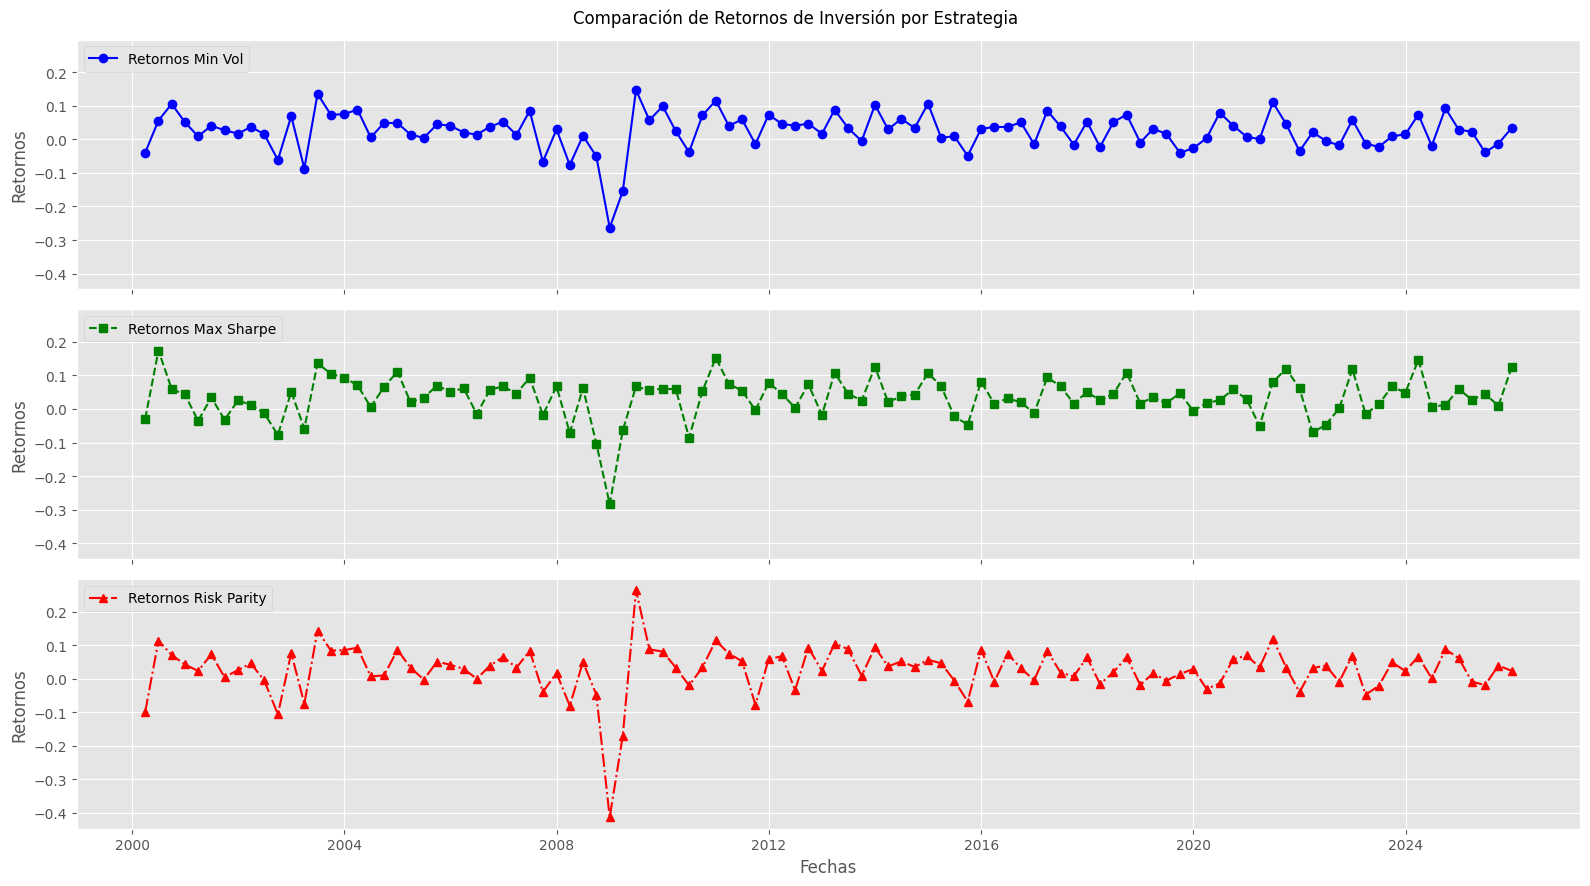

In [ ]:
# Crear una figura y subgráficas
fig, axs = plt.subplots(3, 1, figsize=(16, 9), sharex=True, sharey= True)  # 3 subgráficas, una para cada estrategia, compartiendo el eje x

# Dibujar cada serie de retornos en su propia subgráfica
axs[0].plot(ret3_min_vol, label='Retornos Min Vol', marker='o', linestyle='-', color='blue')
axs[1].plot(ret3_max_sharpe, label='Retornos Max Sharpe', marker='s', linestyle='--', color='green')
axs[2].plot(ret3_risk_parity, label='Retornos Risk Parity', marker='^', linestyle='-.', color='red')

# Añadir título general y etiquetas
fig.suptitle('Comparación de Retornos de Inversión por Estrategia')
for ax in axs:
    ax.set_ylabel('Retornos')
    ax.legend(loc='upper left')  # Colocar leyenda en la parte superior izquierda

# Etiqueta para el eje x solo en la subgráfica inferior
axs[2].set_xlabel('Fechas')

# Ajustar automáticamente el layout
fig.tight_layout()  # Ajusta la subgráfica para dejar espacio para el título general

# Mostrar la gráfica
plt.show()


## Resumen del Análisis de Rebalanceo y Variabilidad en los Pesos de los Activos

Nuestro análisis previo se centró en observar cómo el valor de las carteras cambia a lo largo del tiempo, sin abordar las transacciones de rebalanceo necesarias para mantener las estrategias de asignación de activos. Estas transacciones son cruciales, ya que influyen significativamente en los costos operativos y el rendimiento total de la cartera.

Además, nos enfocaremos en la variabilidad de los pesos asignados a cada activo durante los rebalanceos. Para ello, calcularemos y analizaremos la diferencia entre el peso más alto y el más bajo registrado por cada activo a lo largo de todos los periodos de rebalanceo. Este análisis nos ayudará a entender la volatilidad en la asignación de los activos y evaluar cómo los ajustes frecuentes pueden afectar la estabilidad y eficiencia de nuestras estrategias de inversión.





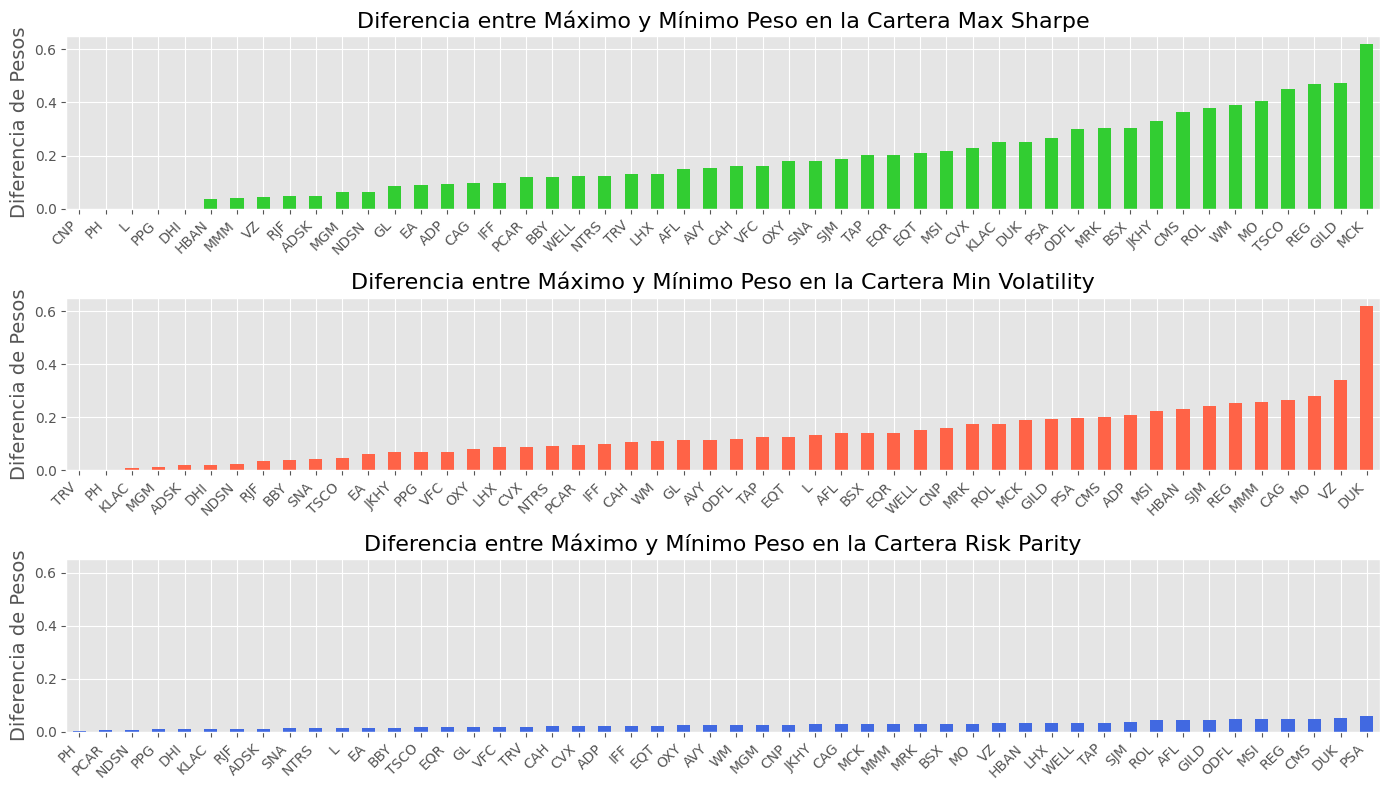

In [ ]:

# Configuración inicial de las subgráficas
fig, axes = plt.subplots(3, 1, figsize=(14, 8),  sharey=True)

# Diccionario para mapear los DataFrames a los ejes y colores
dataframes = {
    "Max Sharpe": (pesos_ini_max_sharpe, 'limegreen'),
    "Min Volatility": (pesos_ini_min_vol, 'tomato'),
    "Risk Parity": (pesos_ini_risk_parity, 'royalblue')
}

# Iterar sobre cada tipo de cartera y su eje correspondiente
for (title, (df, color)), ax in zip(dataframes.items(), axes.flatten()):
    # Calcular la diferencia entre el máximo y el mínimo peso para cada activo
    max_min_diff = df.max() - df.min()

    # Ordenar las diferencias para mejor visualización
    max_min_diff_sorted = max_min_diff.sort_values()

      # Eliminar el nombre del índice 'Ticker' para que no salga en la gráfica
    max_min_diff_sorted.index.name = None

    # Graficar la diferencia de pesos como un gráfico de barras
    max_min_diff_sorted.plot(kind='bar', color=color, ax=ax)

    # Añadir títulos y etiquetas
    ax.set_title(f'Diferencia entre Máximo y Mínimo Peso en la Cartera {title}', fontsize=16)
    ax.set_ylabel('Diferencia de Pesos', fontsize=14)
    #ax.set_xlabel('Activos', fontsize=14)

    # Rotar las etiquetas del eje x para mejor legibilidad
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

# Mejorar el layout para no solapar los gráficos
fig.tight_layout()

# Mostrar el gráfico
plt.show()
